In [1]:
# Imports and plotting setups
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sys, os

import math_funcs

from cycler import cycler

default_cycler = (cycler(color=['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']) +
                cycler(linestyle=['-', '--', ':', '-.', '-', '--', ':']))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

plt.rcParams["font.family"] = "Times"
plt.rcParams["font.size"] = 8

plt.rcParams['figure.figsize'] = (5.5, 2.5)
plt.rcParams['figure.dpi'] = 600

plt.rcParams['text.usetex'] = True

from utils import *

In [2]:
ice_surface_temperature = 273 # K
sqrt_real_surface_ice_espilon_relative = np.sqrt(np.real(ice_epsilon_relative(ice_surface_temperature)))
normal_incidence_fresnel_reflectivity_for_downwelling_brightness_temperature = \
    ((1 - sqrt_real_surface_ice_espilon_relative) / (1 + sqrt_real_surface_ice_espilon_relative))**2
normal_incidence_fresnel_transmission_for_downwelling_brightness_temperature = \
    1 - normal_incidence_fresnel_reflectivity_for_downwelling_brightness_temperature

class hf():
    hackrf_noise_figure = 11 # dB
    transmit_power = 30 # dBm
    brightness_temperature_downwelling = 2.9e6
    brightness_temperature_downwelling_in_ice = brightness_temperature_downwelling \
        * normal_incidence_fresnel_transmission_for_downwelling_brightness_temperature
    brightness_temperature_upwelling = 290
    antenna_noise_temperature = brightness_temperature_downwelling_in_ice * 0.75 \
        + brightness_temperature_upwelling * 0.25
    antenna_physical_temperature = 273
    receiver_physical_temperature = 290
    receiver_bw = 10e3

class uhf():
    hackrf_noise_figure = 10 # dB
    transmit_power = 30 # dBm
    brightness_temperature_downwelling = 29
    brightness_temperature_downwelling_in_ice = brightness_temperature_downwelling \
        * normal_incidence_fresnel_transmission_for_downwelling_brightness_temperature
    brightness_temperature_upwelling = 290
    antenna_noise_temperature = brightness_temperature_downwelling_in_ice * 0.25 \
        + brightness_temperature_upwelling * 0.75
    antenna_physical_temperature = 273
    receiver_physical_temperature = 290
    receiver_bw = 10e3

discretization_distance = 10 # m
distance = 1e3 # m

In [3]:
def imaginary_relative_permittivity_from_hf_limit_conductivity(conductivity, frequency):
    """
    Approach based on the Stillman 2013
    """
    return conductivity / (2 * np.pi * frequency * epsilon_0)

def stillman_2013_ice_wave_number(conductivity, frequency, T):
    empirical_epsilon_relative = np.real(ice_epsilon_relative(T)) \
        - 1j * imaginary_relative_permittivity_from_hf_limit_conductivity(conductivity, frequency)
    return 2 * np.pi * frequency * np.sqrt(epsilon_0 * mu_0) * np.sqrt(empirical_epsilon_relative)

ice_wave_number(uhf_antenna.carrier_frequency, 273), stillman_2013_ice_wave_number(10e-6, uhf_antenna.carrier_frequency, 273)

((15.45566035255216-0.0023442389265602684j),
 (15.455660210772836-0.001054926561345525j))

In [4]:
link_df = pd.DataFrame({'Distance':np.arange(0, distance, discretization_distance)+discretization_distance})

link_df['T(K)'] = 273

link_df['UHF Ice Wave Number'] = ice_wave_number(uhf_antenna.carrier_frequency, link_df['T(K)'])
link_df['UHF Discretized Linear Loss'] = np.e**(2 * discretization_distance * np.imag(link_df['UHF Ice Wave Number']))
link_df['UHF Linear Loss'] = link_df['UHF Discretized Linear Loss'].cumprod()

link_df['UHF Stillman 2013 Ice Wave Number High'] = stillman_2013_ice_wave_number(40e-6, uhf_antenna.carrier_frequency, link_df['T(K)'])
link_df['UHF Stillman 2013 Discretized Linear Loss High'] = np.e**(2 * discretization_distance * np.imag(link_df['UHF Stillman 2013 Ice Wave Number High']))
link_df['UHF Stillman 2013 Linear Loss High'] = link_df['UHF Stillman 2013 Discretized Linear Loss High'].cumprod()

link_df['UHF Stillman 2013 Ice Wave Number Low'] = stillman_2013_ice_wave_number(10e-6, uhf_antenna.carrier_frequency, link_df['T(K)'])
link_df['UHF Stillman 2013 Discretized Linear Loss Low'] = np.e**(2 * discretization_distance * np.imag(link_df['UHF Stillman 2013 Ice Wave Number Low']))
link_df['UHF Stillman 2013 Linear Loss Low'] = link_df['UHF Stillman 2013 Discretized Linear Loss Low'].cumprod()

link_df['UHF Phase Number'] = np.real(link_df['UHF Ice Wave Number']) * discretization_distance
link_df['UHF Cumulative Phase Number'] = link_df['UHF Phase Number'].cumsum()
link_df['UHF Space Path Loss'] = (1 / (2 * link_df['UHF Cumulative Phase Number']))**2
link_df['UHF Total Loss (dB)'] = 10 * np.log10(link_df['UHF Space Path Loss'] * link_df['UHF Linear Loss'])
link_df['UHF Stillman 2013 High Total Loss (dB)'] = 10 * np.log10(link_df['UHF Space Path Loss'] * link_df['UHF Stillman 2013 Linear Loss High'])
link_df['UHF Stillman 2013 Low Total Loss (dB)'] = 10 * np.log10(link_df['UHF Space Path Loss'] * link_df['UHF Stillman 2013 Linear Loss Low'])
#link_df['Compared space path loss'] = 10 * np.log10((1 / (2 * np.real(link_df['UHF Ice Wave Number']) * (link_df['Distance'])))**2)

link_df['HF Ice Wave Number'] = ice_wave_number(hf_antenna.carrier_frequency, link_df['T(K)'])
link_df['HF Discretized Linear Loss'] = np.e**(2 * discretization_distance * np.imag(link_df['HF Ice Wave Number']))
link_df['HF Linear Loss'] = link_df['HF Discretized Linear Loss'].cumprod()

link_df['HF Stillman 2013 Ice Wave Number High'] = stillman_2013_ice_wave_number(40e-6, hf_antenna.carrier_frequency, link_df['T(K)'])
link_df['HF Stillman 2013 Discretized Linear Loss High'] = np.e**(2 * discretization_distance * np.imag(link_df['HF Stillman 2013 Ice Wave Number High']))
link_df['HF Stillman 2013 Linear Loss High'] = link_df['HF Stillman 2013 Discretized Linear Loss High'].cumprod()

link_df['HF Stillman 2013 Ice Wave Number Low'] = stillman_2013_ice_wave_number(10e-6, hf_antenna.carrier_frequency, link_df['T(K)'])
link_df['HF Stillman 2013 Discretized Linear Loss Low'] = np.e**(2 * discretization_distance * np.imag(link_df['HF Stillman 2013 Ice Wave Number Low']))
link_df['HF Stillman 2013 Linear Loss Low'] = link_df['HF Stillman 2013 Discretized Linear Loss Low'].cumprod()

link_df['HF Phase Number'] = np.real(link_df['HF Ice Wave Number']) * discretization_distance
link_df['HF Cumulative Phase Number'] = link_df['HF Phase Number'].cumsum()
link_df['HF Space Path Loss'] = (1 / (2 * link_df['HF Cumulative Phase Number']))**2 
link_df['HF Total Loss (dB)'] = 10 * np.log10(link_df['HF Space Path Loss'] * link_df['HF Linear Loss'])
link_df['HF Stillman 2013 High Total Loss (dB)'] = 10 * np.log10(link_df['HF Space Path Loss'] * link_df['HF Stillman 2013 Linear Loss High'])
link_df['HF Stillman 2013 Low Total Loss (dB)'] = 10 * np.log10(link_df['HF Space Path Loss'] * link_df['HF Stillman 2013 Linear Loss Low'])
#(1 / (2 * np.real(link_df['HF Ice Wave Number']) * (link_df['Distance'])))**2

link_df


,Distance,T(K),UHF Ice Wave Number,UHF Discretized Linear Loss,UHF Linear Loss,UHF Stillman 2013 Ice Wave Number High,UHF Stillman 2013 Discretized Linear Loss High,UHF Stillman 2013 Linear Loss High,UHF Stillman 2013 Ice Wave Number Low,UHF Stillman 2013 Discretized Linear Loss Low,...,HF Stillman 2013 Linear Loss High,HF Stillman 2013 Ice Wave Number Low,HF Stillman 2013 Discretized Linear Loss Low,HF Stillman 2013 Linear Loss Low,HF Phase Number,HF Cumulative Phase Number,HF Space Path Loss,HF Total Loss (dB),HF Stillman 2013 High Total Loss (dB),HF Stillman 2013 Low Total Loss (dB)
0,10.0,273,15.455660- 0.002344j,0.954197,0.954197,15.455661- 0.004220j,0.919069,0.919069,15.455660- 0.001055j,0.979122,...,0.919086,0.201076-0.001055j,0.979123,0.979123,2.010733,2.010733,0.061835,-12.090336,-12.454125,-12.179315
1,20.0,273,15.455660- 0.002344j,0.954197,0.910493,15.455661- 0.004220j,0.919069,0.844688,15.455660- 0.001055j,0.979122,...,0.844719,0.201076-0.001055j,0.979123,0.958681,2.010733,4.021466,0.015459,-18.113585,-18.841164,-18.291544
2,30.0,273,15.455660- 0.002344j,0.954197,0.868790,15.455661- 0.004220j,0.919069,0.776326,15.455660- 0.001055j,0.979122,...,0.776370,0.201076-0.001055j,0.979123,0.938667,2.010733,6.032198,0.006871,-21.638059,-22.729427,-21.904998
3,40.0,273,15.455660- 0.002344j,0.954197,0.828997,15.455661- 0.004220j,0.919069,0.713497,15.455660- 0.001055j,0.979122,...,0.713550,0.201076-0.001055j,0.979123,0.919070,2.010733,8.042931,0.003865,-24.139483,-25.594640,-24.495401
4,50.0,273,15.455660- 0.002344j,0.954197,0.791026,15.455661- 0.004220j,0.919069,0.655753,15.455660- 0.001055j,0.979122,...,0.655814,0.201076-0.001055j,0.979123,0.899882,2.010733,10.053664,0.002473,-26.080332,-27.899279,-26.525230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,960.0,273,15.455660- 0.002344j,0.954197,0.011099,15.455661- 0.004220j,0.919069,0.000303,15.455660- 0.001055j,0.979122,...,0.000304,0.201076-0.001055j,0.979123,0.131937,2.010733,193.030345,0.000007,-51.987416,-86.911196,-60.529447
96,970.0,273,15.455660- 0.002344j,0.954197,0.010590,15.455661- 0.004220j,0.919069,0.000278,15.455660- 0.001055j,0.979122,...,0.000279,0.201076-0.001055j,0.979123,0.129182,2.010733,195.041078,0.000007,-52.080075,-87.367645,-60.711086
97,980.0,273,15.455660- 0.002344j,0.954197,0.010105,15.455661- 0.004220j,0.919069,0.000256,15.455660- 0.001055j,0.979122,...,0.000256,0.201076-0.001055j,0.979123,0.126485,2.010733,197.051811,0.000006,-52.171811,-87.823170,-60.891801
98,990.0,273,15.455660- 0.002344j,0.954197,0.009642,15.455661- 0.004220j,0.919069,0.000235,15.455660- 0.001055j,0.979122,...,0.000236,0.201076-0.001055j,0.979123,0.123845,2.010733,199.062543,0.000006,-52.262642,-88.277791,-61.071612


In [5]:
# uhf_receiver_transmitter_contribution_only = 2 * 10 * np.log10(uhf_antenna.match_efficiency) \
#     + 2 * 10 * np.log10(uhf_antenna.radiation_efficiency(273)) \
#     + 2 * uhf_antenna.directivity(273) \

# hf_receiver_transmitter_contribution_only =  2 * 10 * np.log10(hf_antenna.match_efficiency) \
#     + 2 * 10 * np.log10(hf_antenna.radiation_efficiency) \
#     + 2 * hf_antenna.directivity \
    
# uhf_receiver_transmitter_contribution_only, 2 * 10 * np.log10(uhf_antenna.radiation_efficiency(273)), hf_receiver_transmitter_contribution_only

In [6]:
uhf_EIRP = \
    uhf.transmit_power \
    + 10 * np.log10(uhf_antenna.match_efficiency) \
    + 10 * np.log10(uhf_antenna.radiation_efficiency(273)) \
    + uhf_antenna.directivity(273)

uhf_received_power = \
    uhf.transmit_power \
    + 2 * 10 * np.log10(uhf_antenna.match_efficiency) \
    + 2 * 10 * np.log10(uhf_antenna.radiation_efficiency(273)) \
    + 2 * uhf_antenna.directivity(273) \
    + link_df['UHF Total Loss (dB)'].min()

uhf_stillman_high_received_power = \
    uhf.transmit_power \
    + 2 * 10 * np.log10(uhf_antenna.match_efficiency) \
    + 2 * 10 * np.log10(uhf_antenna.radiation_efficiency(273)) \
    + 2 * uhf_antenna.directivity(273) \
    + link_df['UHF Stillman 2013 High Total Loss (dB)'].min()

uhf_stillman_low_received_power = \
    uhf.transmit_power \
    + 2 * 10 * np.log10(uhf_antenna.match_efficiency) \
    + 2 * 10 * np.log10(uhf_antenna.radiation_efficiency(273)) \
    + 2 * uhf_antenna.directivity(273) \
    + link_df['UHF Stillman 2013 Low Total Loss (dB)'].min()

hf_EIRP = \
    hf.transmit_power \
    + 10 * np.log10(hf_antenna.match_efficiency) \
    + 10 * np.log10(hf_antenna.radiation_efficiency) \
    + hf_antenna.directivity

hf_received_power = \
    hf.transmit_power \
    + 2 * 10 * np.log10(hf_antenna.match_efficiency) \
    + 2 * 10 * np.log10(hf_antenna.radiation_efficiency) \
    + 2 * hf_antenna.directivity \
    + link_df['HF Total Loss (dB)'].min()

hf_stillman_high_received_power = \
    hf.transmit_power \
    + 2 * 10 * np.log10(hf_antenna.match_efficiency) \
    + 2 * 10 * np.log10(hf_antenna.radiation_efficiency) \
    + 2 * hf_antenna.directivity \
    + link_df['HF Stillman 2013 High Total Loss (dB)'].min()

hf_stillman_low_received_power = \
    hf.transmit_power \
    + 2 * 10 * np.log10(hf_antenna.match_efficiency) \
    + 2 * 10 * np.log10(hf_antenna.radiation_efficiency) \
    + 2 * hf_antenna.directivity \
    + link_df['HF Stillman 2013 Low Total Loss (dB)'].min()

uhf_EIRP, uhf_received_power, uhf_stillman_high_received_power, uhf_stillman_low_received_power, hf_EIRP, hf_received_power, hf_stillman_high_received_power, hf_stillman_low_received_power

(26.158261795086624,
 -87.84762823033282,
 -104.13772910077691,
 -76.64880331708494,
 10.45098040014257,
 -61.450626813648384,
 -97.82956434316856,
 -70.34857580473584)

In [7]:
def noise_temperature_to_noise_power(noise_temperature, bandwidth):
    """Converts noise temperature to power in dBm

    Args:
        noise_temperature (float): Noise temperature in Kelvin
        bandwidth (float): Bandwidth of the receiver

    Returns:
        float: Noise power in dBm
    """
    return 10 * np.log10(noise_temperature * k * bandwidth) + 30

uhf_receiver_noise_temperature = 290 * (10**(uhf.hackrf_noise_figure/10) - 1)
uhf_antenna_terminal_noise_temperature = \
    uhf_antenna.radiation_efficiency(273) * uhf_antenna.match_efficiency * uhf.antenna_noise_temperature \
    + (1 - uhf_antenna.radiation_efficiency(273)) * uhf_antenna.match_efficiency * uhf.antenna_physical_temperature \
    + (1 - uhf_antenna.match_efficiency) * uhf.receiver_physical_temperature
uhf_antenna_terminal_noise_power = noise_temperature_to_noise_power(
    uhf_antenna_terminal_noise_temperature,
    uhf.receiver_bw
)
uhf_system_noise_power = noise_temperature_to_noise_power(
    (uhf_receiver_noise_temperature + uhf_antenna_terminal_noise_temperature),
    uhf.receiver_bw
)

hf_receiver_noise_temperature = 290 * (10**(hf.hackrf_noise_figure/10) - 1)
hf_antenna_terminal_noise_temperature = \
    hf_antenna.radiation_efficiency * hf_antenna.match_efficiency * hf.antenna_noise_temperature \
    + (1 - hf_antenna.radiation_efficiency) * hf_antenna.match_efficiency * hf.antenna_physical_temperature \
    + (1 - hf_antenna.match_efficiency) * hf.receiver_physical_temperature
hf_antenna_terminal_noise_power = noise_temperature_to_noise_power(
    hf_antenna_terminal_noise_temperature,
    hf.receiver_bw
)
hf_system_noise_power = noise_temperature_to_noise_power(
    (hf_receiver_noise_temperature + hf_antenna_terminal_noise_temperature),
    hf.receiver_bw
)

uhf_system_noise_power, hf_system_noise_power

(-124.0154815532621, -116.13255849127253)

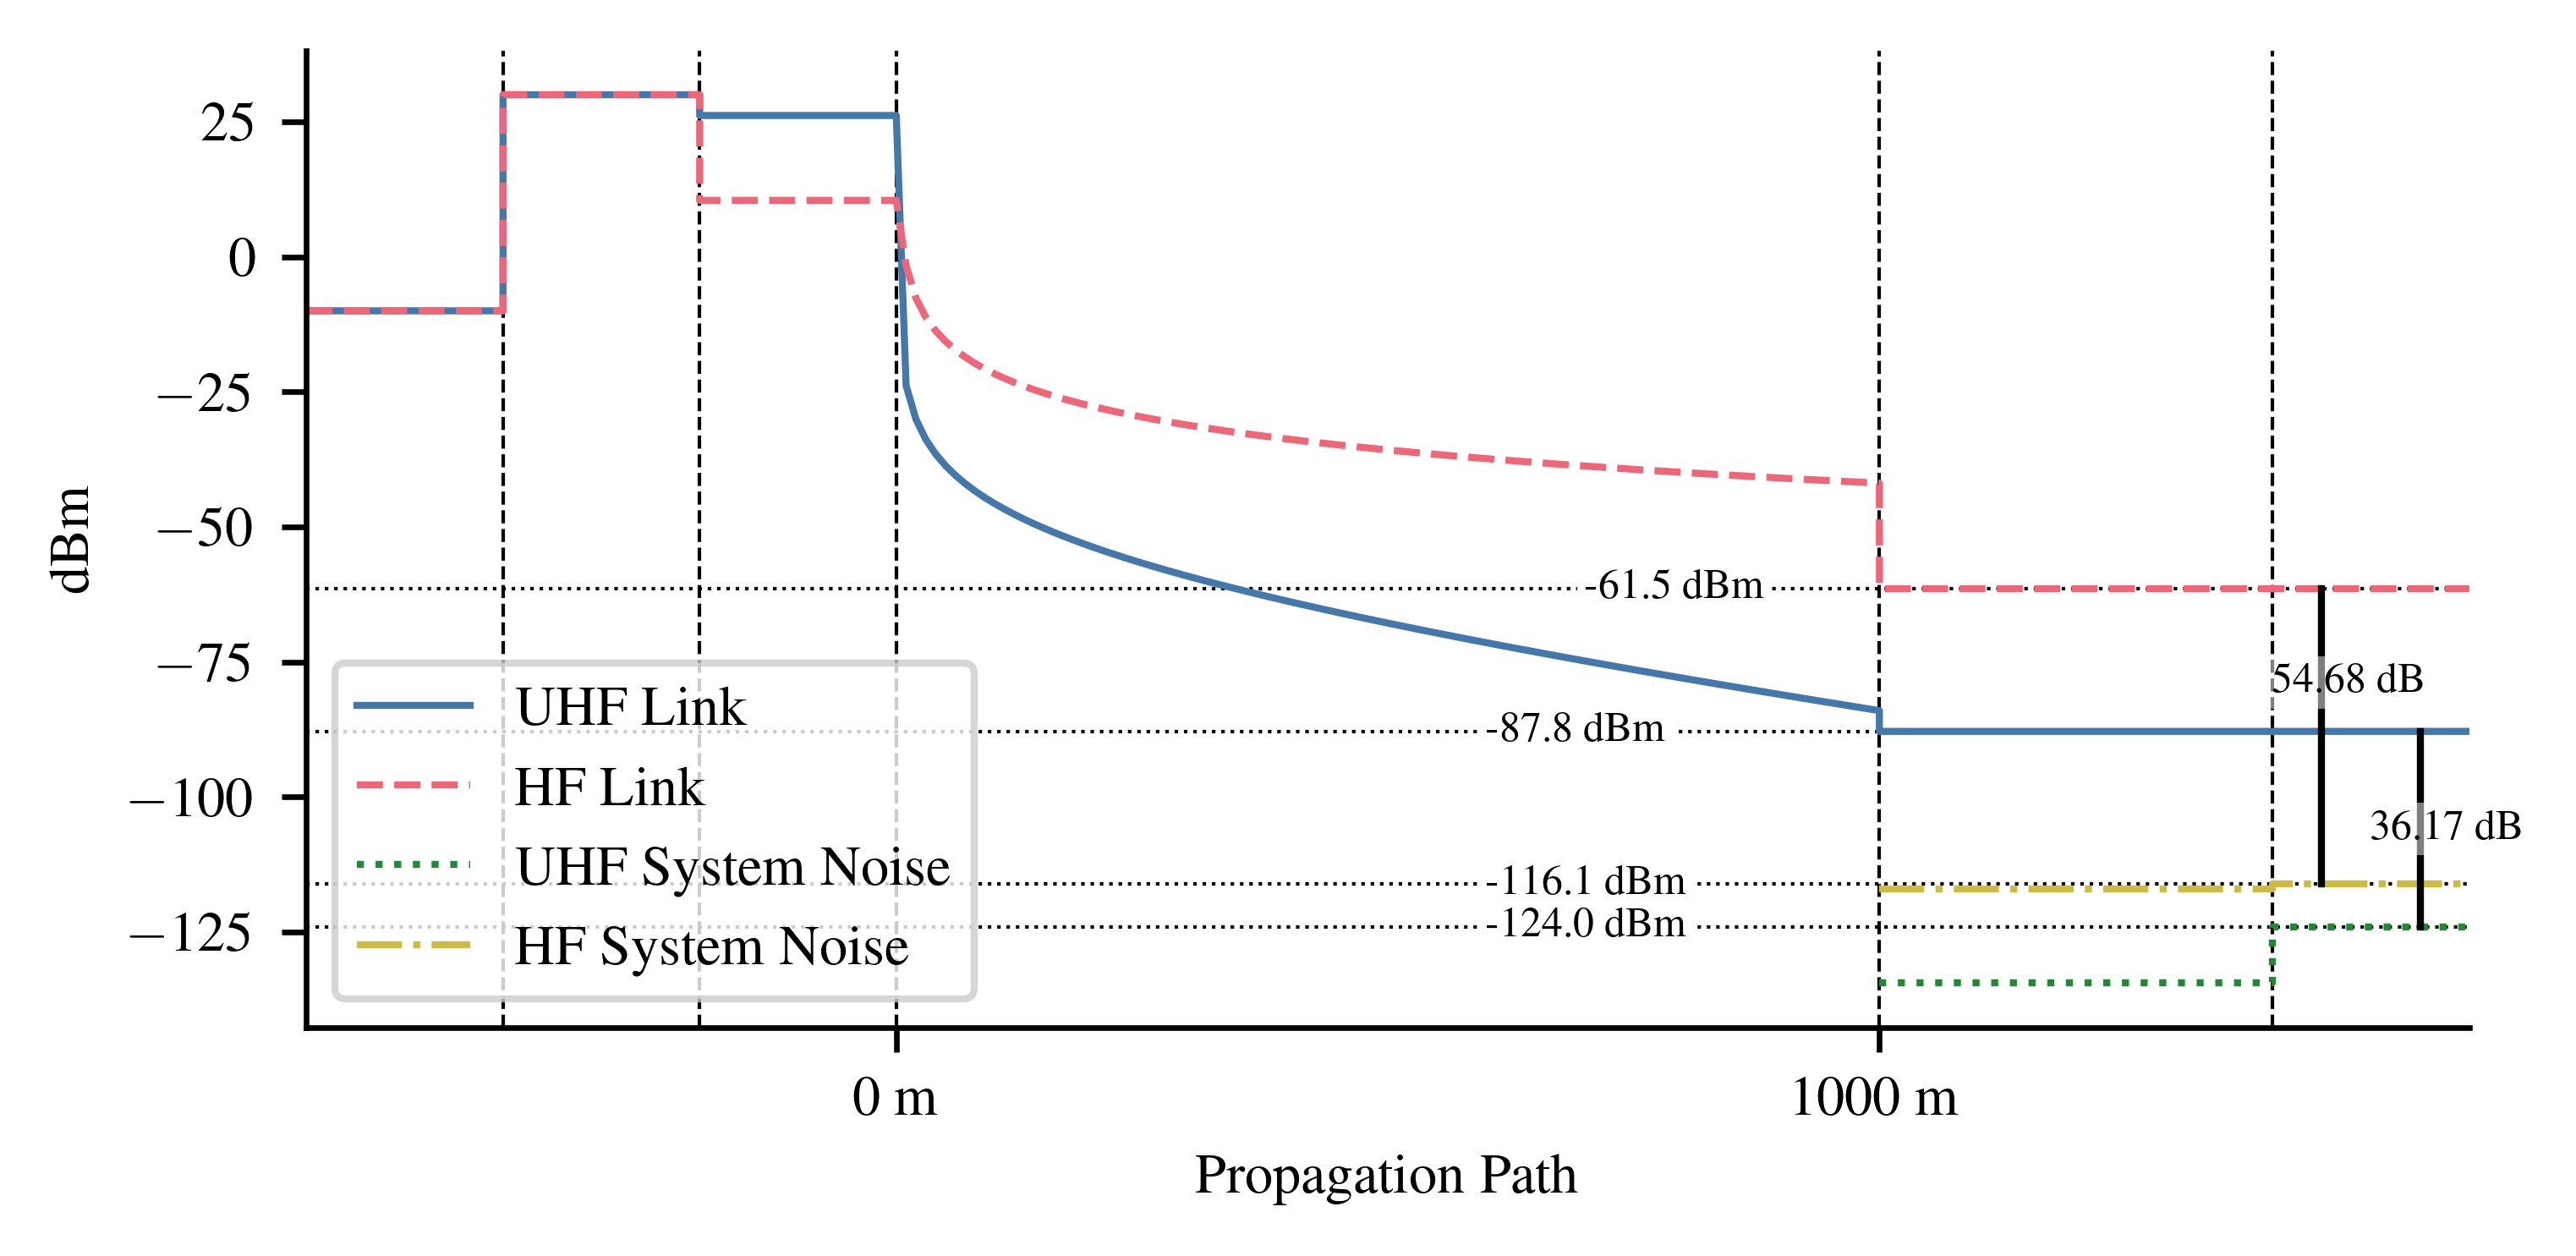

In [22]:
plt.figure()

# Vertical line
plt.axvline(x=-400, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=-200, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=1000, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=1400, color='black', linestyle='--', linewidth=0.5)

plt.axhline(y=hf_received_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    700, 
    hf_received_power, 
    '{0:.1f} dBm'.format(hf_received_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.axhline(y=hf_system_noise_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    600, 
    hf_system_noise_power, 
    '{0:.1f} dBm'.format(hf_system_noise_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.axhline(y=uhf_received_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    600, 
    uhf_received_power, 
    '{0:.1f} dBm'.format(uhf_received_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.axhline(y=uhf_system_noise_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    600, 
    uhf_system_noise_power, 
    '{0:.1f} dBm'.format(uhf_system_noise_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

# Plot the data
plt.plot(
    [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
    [-10, -10, uhf.transmit_power, uhf.transmit_power, uhf_EIRP, uhf_EIRP] \
        + list(link_df['UHF Total Loss (dB)'] + uhf_EIRP) + [uhf_received_power, uhf_received_power], 
    label='UHF Link')
plt.plot(
    [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
    [-10, -10, hf.transmit_power, hf.transmit_power, hf_EIRP, hf_EIRP] \
        + list(link_df['HF Total Loss (dB)'] + hf_EIRP) + [hf_received_power, hf_received_power], 
    label='HF Link')

plt.plot(
    [1000, 1400, 1400, 1600], 
    [uhf_antenna_terminal_noise_power, uhf_antenna_terminal_noise_power, 
        uhf_system_noise_power, uhf_system_noise_power],
    label='UHF System Noise'
)

plt.plot(
    [1000, 1400, 1400, 1600], 
    [hf_antenna_terminal_noise_power, hf_antenna_terminal_noise_power, 
        hf_system_noise_power, hf_system_noise_power],
    label='HF System Noise'
)

# Plot the SNR
plt.plot([1550, 1550], [uhf_received_power, uhf_system_noise_power], color='black', linestyle='-')
plt.text(
        1500, 
        (uhf_received_power + uhf_system_noise_power) / 2,
        f"{uhf_received_power - uhf_system_noise_power:.2f} dB", 
        color='black', va='center', fontsize=6, 
        bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.5)
)

plt.plot([1450, 1450], [hf_received_power, hf_system_noise_power], color='black', linestyle='-')
plt.text(
        1400, 
        (hf_received_power + hf_system_noise_power) / 2+10,
        f"{hf_received_power - hf_system_noise_power:.2f} dB", 
        color='black', va='center', fontsize=6, 
        bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.5)
)

# X-axis tick marks
ticks = [0, 1000]
labels = [f"{tick} m" for tick in ticks]
plt.xticks(ticks, labels)

# Other chart details
plt.xlabel('Propagation Path')
plt.ylabel('dBm')
plt.legend(loc='lower left')

# Remove the right and top bounding box
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Fix the plot so the xlim spans only the whole data set
ax.set_xlim(-600,1600)
ax.set_ylim()

plt.show()

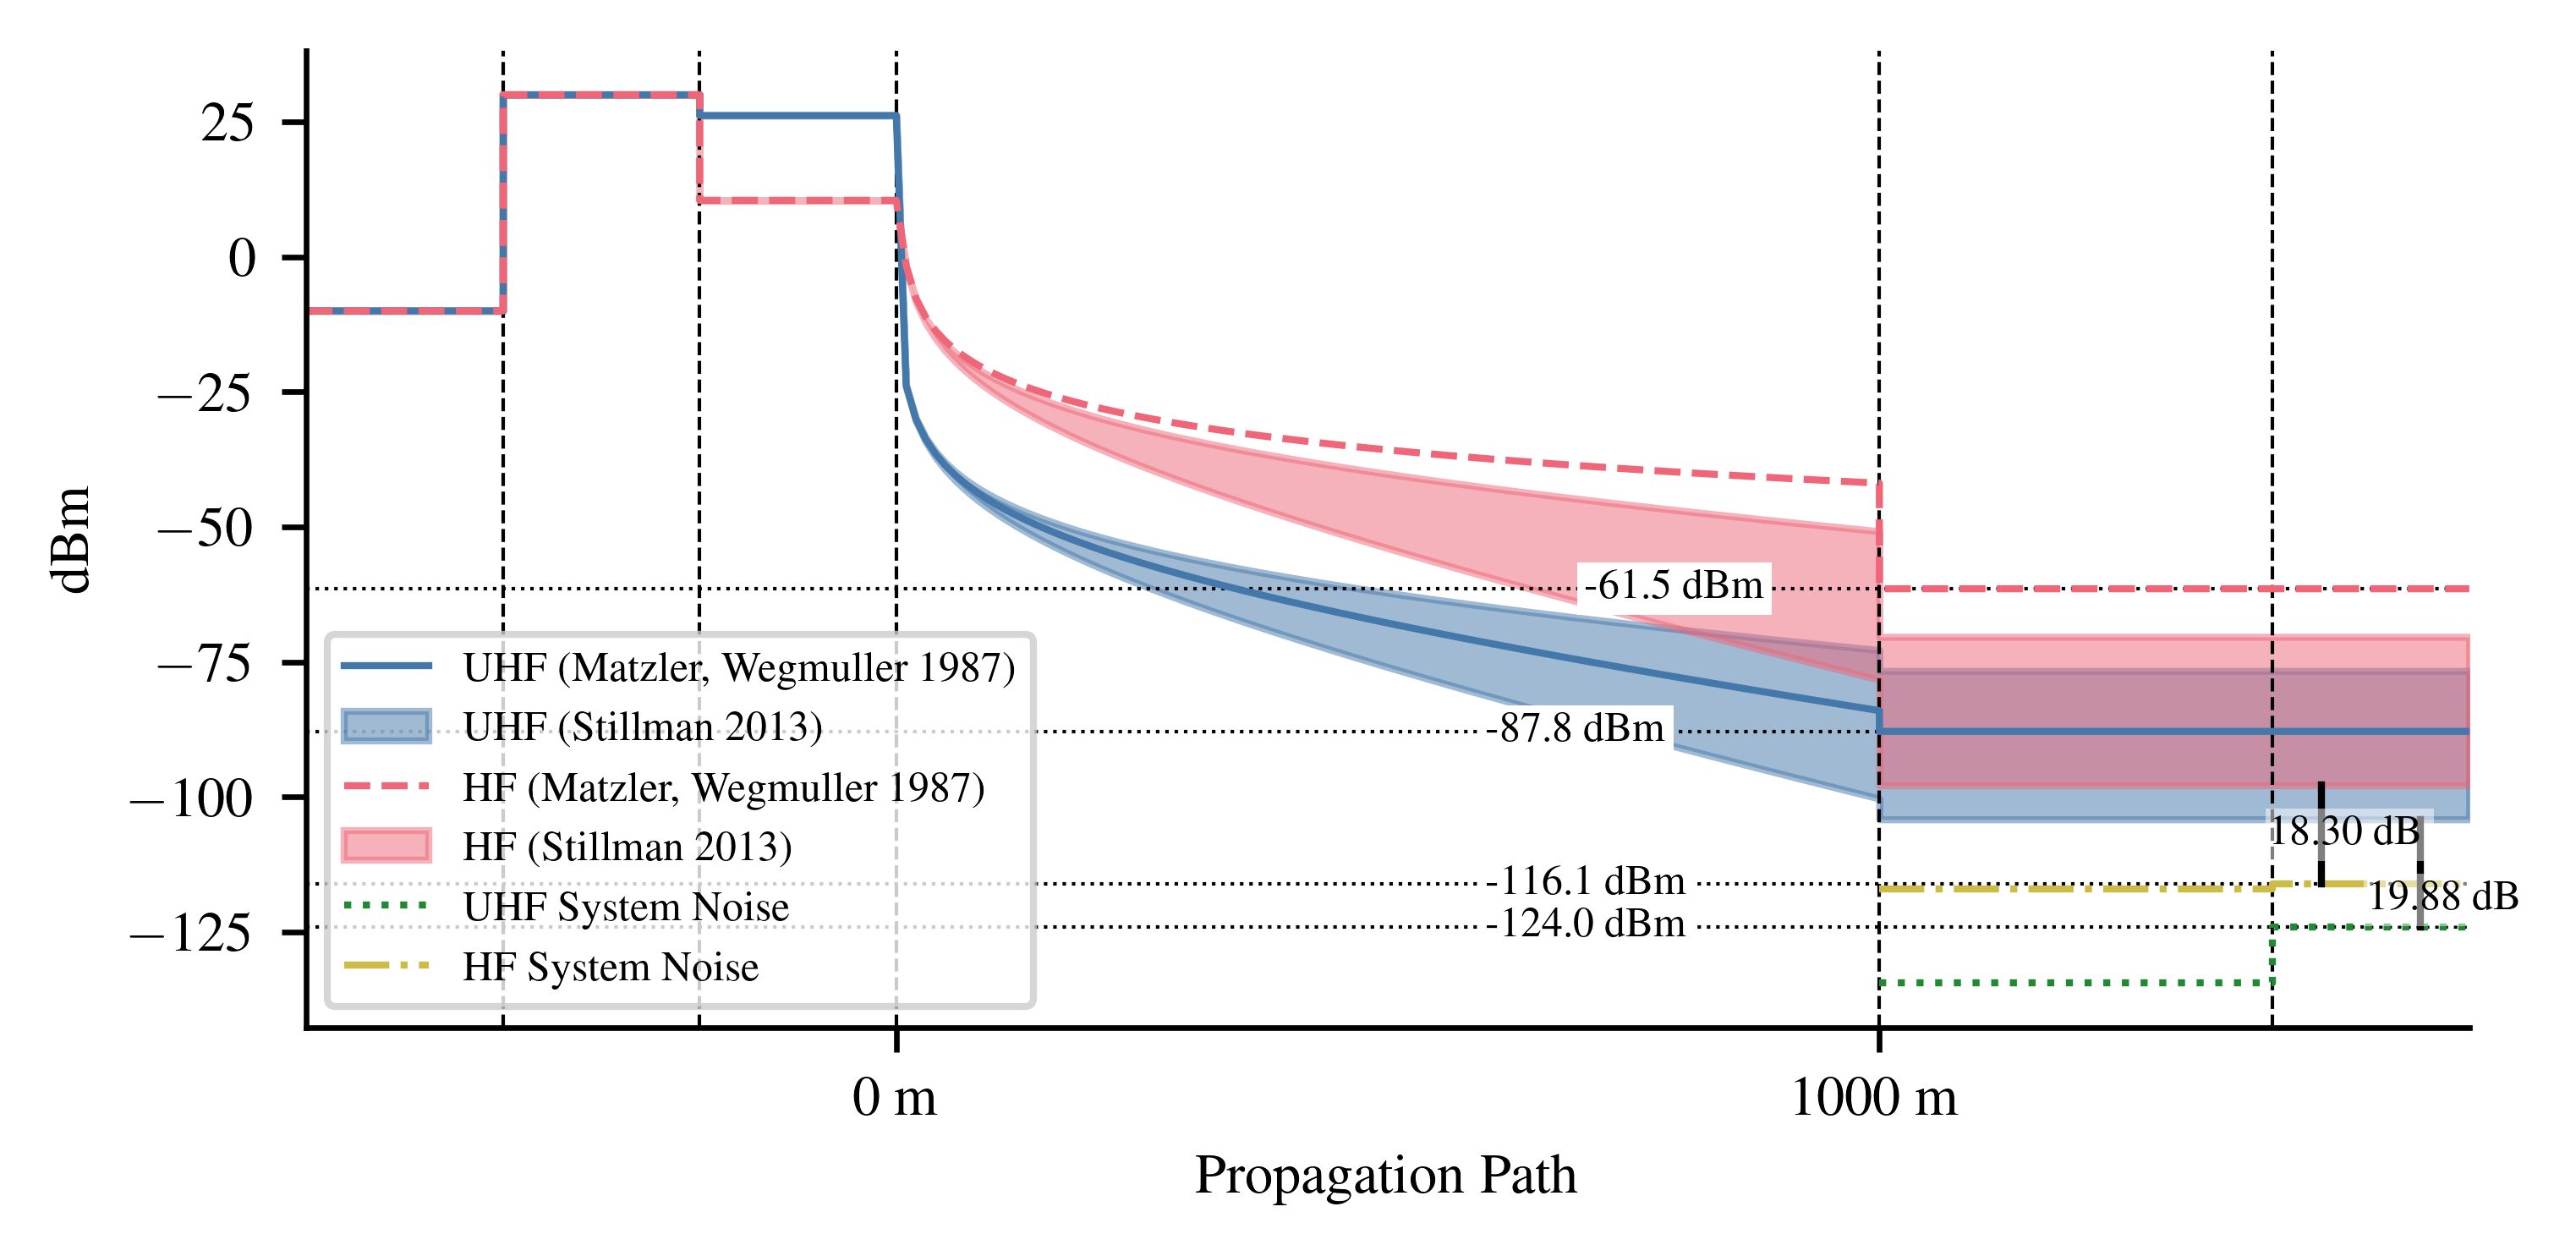

In [20]:
plt.figure()

# Vertical line
plt.axvline(x=-400, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=-200, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=1000, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=1400, color='black', linestyle='--', linewidth=0.5)

plt.axhline(y=hf_received_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    700, 
    hf_received_power, 
    '{0:.1f} dBm'.format(hf_received_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.axhline(y=hf_system_noise_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    600, 
    hf_system_noise_power, 
    '{0:.1f} dBm'.format(hf_system_noise_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.axhline(y=uhf_received_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    600, 
    uhf_received_power, 
    '{0:.1f} dBm'.format(uhf_received_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.axhline(y=uhf_system_noise_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    600, 
    uhf_system_noise_power, 
    '{0:.1f} dBm'.format(uhf_system_noise_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

# Plot the data
plt.plot(
    [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
    [-10, -10, uhf.transmit_power, uhf.transmit_power, uhf_EIRP, uhf_EIRP] \
        + list(link_df['UHF Total Loss (dB)'] + uhf_EIRP) + [uhf_received_power, uhf_received_power], 
    label='UHF (Matzler, Wegmuller 1987)')
# plt.plot(
#     [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
#     [-10, -10, uhf.transmit_power, uhf.transmit_power, uhf_EIRP, uhf_EIRP] \
#         + list(link_df['UHF Stillman 2013 High Total Loss (dB)'] + uhf_EIRP) + [uhf_stillman_high_received_power, uhf_stillman_high_received_power], 
#     label='UHF (Stillman 2013) High')
# plt.plot(
#     [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
#     [-10, -10, uhf.transmit_power, uhf.transmit_power, uhf_EIRP, uhf_EIRP] \
#         + list(link_df['UHF Stillman 2013 Low Total Loss (dB)'] + uhf_EIRP) + [uhf_stillman_low_received_power, uhf_stillman_low_received_power], 
#     label='UHF (Stillman 2013) Low')
plt.fill_between(
    [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
    [-10, -10, uhf.transmit_power, uhf.transmit_power, uhf_EIRP, uhf_EIRP] \
        + list(link_df['UHF Stillman 2013 High Total Loss (dB)'] + uhf_EIRP) + [uhf_stillman_high_received_power, uhf_stillman_high_received_power], 
    [-10, -10, uhf.transmit_power, uhf.transmit_power, uhf_EIRP, uhf_EIRP] \
        + list(link_df['UHF Stillman 2013 Low Total Loss (dB)'] + uhf_EIRP) + [uhf_stillman_low_received_power, uhf_stillman_low_received_power],
    label='UHF (Stillman 2013)', color='#4477AA', alpha=0.5
)

plt.plot(
    [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
    [-10, -10, hf.transmit_power, hf.transmit_power, hf_EIRP, hf_EIRP] \
        + list(link_df['HF Total Loss (dB)'] + hf_EIRP) + [hf_received_power, hf_received_power], 
    label='HF (Matzler, Wegmuller 1987)')
# plt.plot(
#     [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
#     [-10, -10, hf.transmit_power, hf.transmit_power, hf_EIRP, hf_EIRP] \
#         + list(link_df['HF Stillman 2013 High Total Loss (dB)'] + hf_EIRP) + [hf_stillman_high_received_power, hf_stillman_high_received_power], 
#     label='HF (Stillman 2013) High')
# plt.plot(
#     [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
#     [-10, -10, hf.transmit_power, hf.transmit_power, hf_EIRP, hf_EIRP] \
#         + list(link_df['HF Stillman 2013 Low Total Loss (dB)'] + hf_EIRP) + [hf_stillman_low_received_power, hf_stillman_low_received_power], 
#     label='HF (Stillman 2013) Low')
plt.fill_between(
    [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
    [-10, -10, hf.transmit_power, hf.transmit_power, hf_EIRP, hf_EIRP] \
        + list(link_df['HF Stillman 2013 High Total Loss (dB)'] + hf_EIRP) + [hf_stillman_high_received_power, hf_stillman_high_received_power],
    [-10, -10, hf.transmit_power, hf.transmit_power, hf_EIRP, hf_EIRP] \
        + list(link_df['HF Stillman 2013 Low Total Loss (dB)'] + hf_EIRP) + [hf_stillman_low_received_power, hf_stillman_low_received_power], 
    label='HF (Stillman 2013)', color='#EE6677', alpha=0.5
)

# Plot the noise
plt.plot(
    [1000, 1400, 1400, 1600], 
    [uhf_antenna_terminal_noise_power, uhf_antenna_terminal_noise_power, 
        uhf_system_noise_power, uhf_system_noise_power],
    label='UHF System Noise'
)

plt.plot(
    [1000, 1400, 1400, 1600], 
    [hf_antenna_terminal_noise_power, hf_antenna_terminal_noise_power, 
        hf_system_noise_power, hf_system_noise_power],
    label='HF System Noise'
)

# Plot the SNR
plt.plot([1550, 1550], [uhf_stillman_high_received_power, uhf_system_noise_power], color='black', linestyle='-')
plt.text(
        1500, 
        (uhf_stillman_high_received_power + uhf_system_noise_power) / 2 - 5,
        f"{uhf_stillman_high_received_power - uhf_system_noise_power:.2f} dB", 
        color='black', va='center', fontsize=6, 
        bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.5)
)

plt.plot([1450, 1450], [hf_stillman_high_received_power, hf_system_noise_power], color='black', linestyle='-')
plt.text(
        1400, 
        (hf_stillman_high_received_power + hf_system_noise_power) / 2,
        f"{hf_stillman_high_received_power - hf_system_noise_power:.2f} dB", 
        color='black', va='center', fontsize=6, 
        bbox=dict(facecolor='white', edgecolor='none', pad=1, alpha=0.5)
)

# X-axis tick marks
ticks = [0, 1000]
labels = [f"{tick} m" for tick in ticks]
plt.xticks(ticks, labels)

# Other chart details
plt.xlabel('Propagation Path')
plt.ylabel('dBm')
plt.legend(loc='lower left', fontsize=6)

# Remove the right and top bounding box
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Fix the plot so the xlim spans only the whole data set
ax.set_xlim(-600,1600)
ax.set_ylim()

plt.show()